## **STEP1. 패키지 및 데이터 로딩**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [52]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import rc 

plt.rcParams["axes.unicode_minus"] = False 
rc("font", family="Malgun Gothic")
# %matplotlib inline 
get_ipython().run_line_magic("matplotlib", "inline")

In [2]:
# # 한글 표시 설정
# import matplotlib as mpl
# %config InlineBackend.figure_format = 'retina'
 
# !apt -qq -y install fonts-nanum
 
# import matplotlib.font_manager as fm
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=9)
# plt.rc('font', family='NanumBarunGothic') 
# mpl.font_manager._rebuild()

# # 마이너스 기호 정상 출력을 위한 코드
# plt.rc('axes', unicode_minus=False)

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [64]:
train = pd.read_csv('../parking_data/train.csv')
test = pd.read_csv('../parking_data/test.csv')
submission = pd.read_csv('../parking_data/sample_submission.csv')

---

## **STEP2. 데이터 탐색**

In [65]:
train.shape, test.shape

((2952, 15), (1022, 14))

In [66]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [67]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


---

### 2-1. 컬럼명 변경

* 도보 10분거리 내 지하철역 수(환승노선 수 반영) → 지하철역수
* 도보 10분거리 내 버스정류장 수 → 버스정류장수

In [68]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')

In [69]:
train.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금', '임대료', '지하철역수','버스정류장수', '단지내주차면수', '등록차량수']
test.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금', '임대료', '지하철역수','버스정류장수', '단지내주차면수']

### 2-2. 데이터 타입 및 결측치 확인


####Train Data

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2952 non-null   object 
 1   총세대수      2952 non-null   int64  
 2   임대건물구분    2952 non-null   object 
 3   지역        2952 non-null   object 
 4   공급유형      2952 non-null   object 
 5   전용면적      2952 non-null   float64
 6   전용면적별세대수  2952 non-null   int64  
 7   공가수       2952 non-null   float64
 8   자격유형      2952 non-null   object 
 9   임대보증금     2383 non-null   object 
 10  임대료       2383 non-null   object 
 11  지하철역수     2741 non-null   float64
 12  버스정류장수    2948 non-null   float64
 13  단지내주차면수   2952 non-null   float64
 14  등록차량수     2952 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 346.1+ KB


In [71]:
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       569
임대료         569
지하철역수       211
버스정류장수        4
단지내주차면수       0
등록차량수         0
dtype: int64

#### Test Data

In [72]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      1022 non-null   object 
 1   총세대수      1022 non-null   int64  
 2   임대건물구분    1022 non-null   object 
 3   지역        1022 non-null   object 
 4   공급유형      1022 non-null   object 
 5   전용면적      1022 non-null   float64
 6   전용면적별세대수  1022 non-null   int64  
 7   공가수       1022 non-null   float64
 8   자격유형      1020 non-null   object 
 9   임대보증금     842 non-null    object 
 10  임대료       842 non-null    object 
 11  지하철역수     980 non-null    float64
 12  버스정류장수    1022 non-null   float64
 13  단지내주차면수   1022 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 111.9+ KB


In [73]:
test.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          2
임대보증금       180
임대료         180
지하철역수        42
버스정류장수        0
단지내주차면수       0
dtype: int64

## **STEP3. 데이터 전처리**

### 3-1. 결측치 대체

#### 지하철역수
* 지하철역수 컬럼에 결측치가 존재하는 지역 : 충청남도, 대전광역시, 경상남도
* 카카오맵에서 [지역명 + '임대주택']으로 검색한 결과, 충청남도/대전광역시/경상남도의 공공임대주택단지들 중에서 도보로 10분 이내에 지하철역으로 이동 가능한 주택단지는 없음.
* 따라서, 지하철역수 컬럼의 결측치는 모두 0으로 대체함.

In [74]:
train[train['지하철역수'].isnull()]['지역'].unique()

array(['충청남도', '대전광역시', '경상남도'], dtype=object)

In [75]:
train['지하철역수'] = train['지하철역수'].fillna(0)

In [76]:
test['지하철역수'] = test['지하철역수'].fillna(0)

In [77]:
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       569
임대료         569
지하철역수         0
버스정류장수        4
단지내주차면수       0
등록차량수         0
dtype: int64

In [78]:
test.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          2
임대보증금       180
임대료         180
지하철역수         0
버스정류장수        0
단지내주차면수       0
dtype: int64

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2952 non-null   object 
 1   총세대수      2952 non-null   int64  
 2   임대건물구분    2952 non-null   object 
 3   지역        2952 non-null   object 
 4   공급유형      2952 non-null   object 
 5   전용면적      2952 non-null   float64
 6   전용면적별세대수  2952 non-null   int64  
 7   공가수       2952 non-null   float64
 8   자격유형      2952 non-null   object 
 9   임대보증금     2383 non-null   object 
 10  임대료       2383 non-null   object 
 11  지하철역수     2952 non-null   float64
 12  버스정류장수    2948 non-null   float64
 13  단지내주차면수   2952 non-null   float64
 14  등록차량수     2952 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 346.1+ KB


#### 버스정류장수
* 버스정류장수 컬럼에 결측치가 존재하는 지역 : 경상남도
* 카카오맵에서 확인한 결과, 경상남도 공공임대주택단지에서 도보 10분 이내로 이동 가능한 버스정류장 수는 평균 2.6개
    - 김해진례 공공지원민간임대주택 공급촉진지구: 0개
    - 거제송정 기업형임대주택 공급촉진지구: 2개
    - 양산덕계 공공지원민간임대주택 공급촉진지구: 5개
    - 사천송지 기업형임대주택 공급촉진지구: 2개
    - 창원안민 공공지원 민간임대주택 공급촉진지구: 4개
* 버스정류장수 컬럼의 결측치는 2.6개를 반올림한 3개로 대체


In [80]:
train[train['버스정류장수'].isnull()]['지역'].unique()

array(['경상남도'], dtype=object)

In [81]:
train['버스정류장수'] = train['버스정류장수'].fillna(3)

In [82]:
test.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          2
임대보증금       180
임대료         180
지하철역수         0
버스정류장수        0
단지내주차면수       0
dtype: int64

#### 자격유형
* 자격유형 컬럼의 결측치는 2개인데, 서로 다른 단지 코드를 가지고 있음
* 단지코드가 'C2411'인 결측치의 경우 같은 단지코드를 가진 다른 데이터에서 자격유형이 모두 'A'로 나왔기 때문에, 똑같이 'A'로 대체함
* 단지코드가 'C2253'인 결측치의 경우 같은 단지코드를 가진 다른 데이터에서 자격유형 최빈값이 'D'라고 나왔지만, 자격유형 'D'의 경우 상가에 해당하여 결측치에는 해당하지 않는 것으로 보임. 결측치와 같은 건물유형인 아파트의 경우 자격유형이 모두 'C'라고 나타났기 때문에, 결측치는 'C'로 대체함

In [83]:
test[test['자격유형'].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [84]:
test[test['단지코드'] == 'C2411']['자격유형'].mode()

0    A
dtype: object

In [85]:
test[test['단지코드'] == 'C2411']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0.0,2.0,840.0


In [86]:
test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [87]:
test[test['단지코드'] == 'C2253']['자격유형'].mode()

0    D
dtype: object

In [88]:
test[test['단지코드'] == 'C2253']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0.0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0.0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0.0,2.0,173.0
263,C2253,1161,상가,강원도,임대상가,22.91,1,0.0,D,NaN,NaN,0.0,2.0,173.0
264,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,NaN,NaN,0.0,2.0,173.0
265,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,NaN,NaN,0.0,2.0,173.0
266,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,NaN,NaN,0.0,2.0,173.0
267,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,NaN,NaN,0.0,2.0,173.0


In [89]:
test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

#### 임대보증금/임대료

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2952 non-null   object 
 1   총세대수      2952 non-null   int64  
 2   임대건물구분    2952 non-null   object 
 3   지역        2952 non-null   object 
 4   공급유형      2952 non-null   object 
 5   전용면적      2952 non-null   float64
 6   전용면적별세대수  2952 non-null   int64  
 7   공가수       2952 non-null   float64
 8   자격유형      2952 non-null   object 
 9   임대보증금     2383 non-null   object 
 10  임대료       2383 non-null   object 
 11  지하철역수     2952 non-null   float64
 12  버스정류장수    2952 non-null   float64
 13  단지내주차면수   2952 non-null   float64
 14  등록차량수     2952 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 346.1+ KB


In [91]:
df_tmp = train[(train['임대보증금'].notnull()) & (train['임대료'].notnull())].copy()
df_tmp.shape

(2383, 15)

In [92]:
df_tmp.loc[df_tmp['임대보증금'] == '-', '임대보증금'] = 0
df_tmp.loc[df_tmp['임대료'] == '-', '임대료'] = 0

In [93]:
df_tmp = df_tmp.astype({'임대보증금':'int', '임대료':'int'})
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2383 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2383 non-null   object 
 1   총세대수      2383 non-null   int64  
 2   임대건물구분    2383 non-null   object 
 3   지역        2383 non-null   object 
 4   공급유형      2383 non-null   object 
 5   전용면적      2383 non-null   float64
 6   전용면적별세대수  2383 non-null   int64  
 7   공가수       2383 non-null   float64
 8   자격유형      2383 non-null   object 
 9   임대보증금     2383 non-null   int32  
 10  임대료       2383 non-null   int32  
 11  지하철역수     2383 non-null   float64
 12  버스정류장수    2383 non-null   float64
 13  단지내주차면수   2383 non-null   float64
 14  등록차량수     2383 non-null   float64
dtypes: float64(6), int32(2), int64(2), object(5)
memory usage: 279.3+ KB


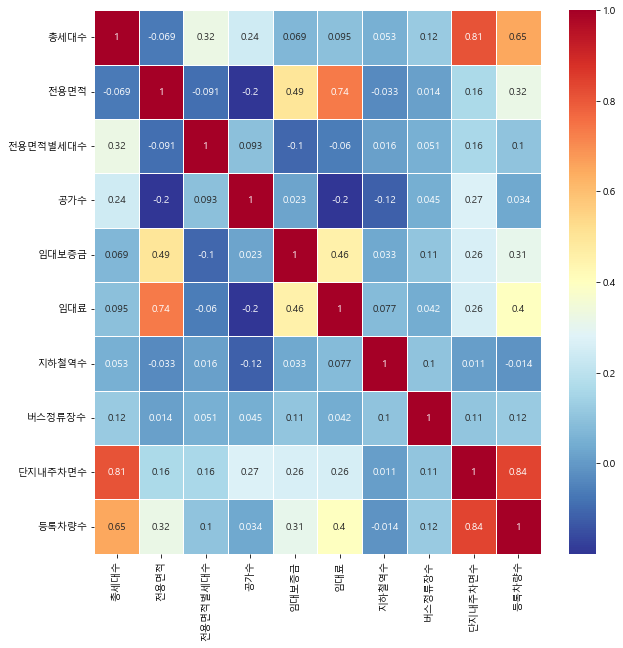

In [94]:
plt.figure(figsize=(10,10))
sns.heatmap(df_tmp.corr(), annot=True, cmap='RdYlBu_r', linewidths=0.5)
plt.show()

In [95]:
train[train['임대보증금'] == '-'] 

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수
2547,C1326,1934,아파트,부산광역시,국민임대,24.72,472,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2548,C1326,1934,아파트,부산광역시,국민임대,24.79,104,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2549,C1326,1934,아파트,부산광역시,국민임대,26.83,590,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2550,C1326,1934,아파트,부산광역시,국민임대,37.70,464,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2551,C1326,1934,아파트,부산광역시,국민임대,46.94,304,43.0,H,-,-,0.0,4.0,1670.0,1153.0
2680,C1786,480,아파트,강원도,행복주택,16.91,156,25.0,K,-,-,0.0,3.0,338.0,345.0
2681,C1786,480,아파트,강원도,행복주택,26.90,136,25.0,K,-,-,0.0,3.0,338.0,345.0
2682,C1786,480,아파트,강원도,행복주택,26.90,72,25.0,K,-,-,0.0,3.0,338.0,345.0
2683,C1786,480,아파트,강원도,행복주택,26.90,24,25.0,K,-,-,0.0,3.0,338.0,345.0
2906,C2186,924,아파트,대구광역시,국민임대,29.17,238,0.0,H,-,-,0.0,8.0,664.0,744.0


In [96]:
# 부산광역시, https://www.myhome.go.kr/hws/portal/sch/selectRsdtRcritNtcDetailView.do?pblancId=10445

train.loc[(train['임대보증금'] == '-') & (train['단지코드'] == 'C1326') & (train['전용면적'] == 24.72), '임대보증금'] = 7505000
train.loc[(train['임대료'] == '-') & (train['단지코드'] == 'C1326') & (train['전용면적'] == 24.72), '임대료'] = 144740

train.loc[(train['임대보증금'] == '-') & (train['단지코드'] == 'C1326') & (train['전용면적'] == 24.79), '임대보증금'] = 7505000
train.loc[(train['임대료'] == '-') & (train['단지코드'] == 'C1326') & (train['전용면적'] == 24.79), '임대료'] = 144740

train.loc[(train['임대보증금'] == '-') & (train['단지코드'] == 'C1326') & (train['전용면적'] == 26.83), '임대보증금'] = 8148000
train.loc[(train['임대료'] == '-') & (train['단지코드'] == 'C1326') & (train['전용면적'] == 26.83), '임대료'] = 152250

train.loc[(train['임대보증금'] == '-') & (train['단지코드'] == 'C1326') & (train['전용면적'] == 37.70), '임대보증금'] = 15868000
train.loc[(train['임대료'] == '-') & (train['단지코드'] == 'C1326') & (train['전용면적'] == 37.70), '임대료'] = 212290

train.loc[(train['임대보증금'] == '-') & (train['단지코드'] == 'C1326') & (train['전용면적'] == 46.94), '임대보증금'] = 24768000
train.loc[(train['임대료'] == '-') & (train['단지코드'] == 'C1326') & (train['전용면적'] == 46.94), '임대료'] = 277690

In [97]:
# 강원도, https://www.myhome.go.kr/hws/portal/sch/selectRsdtRcritNtcDetailView.do?pblancId=2224

train.loc[(train['임대보증금'] == '-') & (train['단지코드'] == 'C1786') & (train['전용면적'] == 16.91), '임대보증금'] = 13800000
train.loc[(train['임대료'] == '-') & (train['단지코드'] == 'C1786') & (train['전용면적'] == 16.91), '임대료'] = 67000

train.loc[(train['임대보증금'] == '-') & (train['단지코드'] == 'C1786') & (train['전용면적'] == 26.90), '임대보증금'] = 21400000	
train.loc[(train['임대료'] == '-') & (train['단지코드'] == 'C1786') & (train['전용면적'] == 26.90), '임대료'] = 105000

In [98]:
# 대구광역시, https://www.myhome.go.kr/hws/portal/sch/selectRsdtRcritNtcDetailView.do?pblancId=6925

train.loc[(train['임대보증금'] == '-') & (train['단지코드'] == 'C2186') & (train['전용면적'] == 29.17), '임대보증금'] = 7741000
train.loc[(train['임대료'] == '-') & (train['단지코드'] == 'C2186') & (train['전용면적'] == 29.17), '임대료'] = 133330

train.loc[(train['임대보증금'] == '-') & (train['단지코드'] == 'C2186') & (train['전용면적'] == 29.34), '임대보증금'] = 7741000
train.loc[(train['임대료'] == '-') & (train['단지코드'] == 'C2186') & (train['전용면적'] == 29.34), '임대료'] = 133330

train.loc[(train['임대보증금'] == '-') & (train['단지코드'] == 'C2186') & (train['전용면적'] == 37.43), '임대보증금'] = 10920000
train.loc[(train['임대료'] == '-') & (train['단지코드'] == 'C2186') & (train['전용면적'] == 37.43), '임대료'] = 172240

In [99]:
train[train['임대료'] == '-'] 

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수
2043,C1397,370,아파트,서울특별시,장기전세,23.32,51,9.0,A,87444000,-,0.0,3.0,1590.0,1595.0
2044,C1397,370,아파트,서울특별시,장기전세,46.79,4,9.0,A,174888000,-,0.0,3.0,1590.0,1595.0
2045,C1397,370,아파트,서울특별시,장기전세,46.91,69,9.0,A,174888000,-,0.0,3.0,1590.0,1595.0
2046,C1397,370,아파트,서울특별시,장기전세,51.96,24,9.0,A,194562000,-,0.0,3.0,1590.0,1595.0
2047,C1397,370,아파트,서울특별시,장기전세,51.99,80,9.0,A,194562000,-,0.0,3.0,1590.0,1595.0
2048,C1397,370,아파트,서울특별시,장기전세,59.93,142,9.0,A,216423000,-,0.0,3.0,1590.0,1595.0
2100,C1039,790,아파트,서울특별시,장기전세,51.32,126,13.0,A,187694000,-,0.0,3.0,673.0,645.0
2101,C1039,790,아파트,서울특별시,장기전세,59.88,49,13.0,A,213863000,-,0.0,3.0,673.0,645.0
2102,C1039,790,아파트,서울특별시,장기전세,59.94,75,13.0,A,213863000,-,0.0,3.0,673.0,645.0


In [100]:
# 장기전세는 임대료 없음
train.loc[train['임대료'] == '-', '임대료'] = 0

In [101]:
train[train['임대료'] == '-'] 

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수


---

### 3-2. 데이터 타입 변경
* 정수형으로 나타나야 하는 값들의 데이터타입을 'int'로 변경
* 지하철역수: float → int
* 버스정류장수: float → int
* 단지내주차면수: float → int
* 등록차량수: float → int

In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2952 non-null   object 
 1   총세대수      2952 non-null   int64  
 2   임대건물구분    2952 non-null   object 
 3   지역        2952 non-null   object 
 4   공급유형      2952 non-null   object 
 5   전용면적      2952 non-null   float64
 6   전용면적별세대수  2952 non-null   int64  
 7   공가수       2952 non-null   float64
 8   자격유형      2952 non-null   object 
 9   임대보증금     2383 non-null   object 
 10  임대료       2383 non-null   object 
 11  지하철역수     2952 non-null   float64
 12  버스정류장수    2952 non-null   float64
 13  단지내주차면수   2952 non-null   float64
 14  등록차량수     2952 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 346.1+ KB


In [103]:
train = train[(train['임대료'].notnull()) & (train['임대보증금'].notnull())].copy()
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0


In [104]:
train = train.astype({'임대료': 'int', '임대보증금':'int','지하철역수':'int', '버스정류장수':'int', '단지내주차면수':'int', '등록차량수':'int'})

---

In [105]:
test.loc[test['임대료'] == '-', '임대료'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

In [106]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      1022 non-null   object 
 1   총세대수      1022 non-null   int64  
 2   임대건물구분    1022 non-null   object 
 3   지역        1022 non-null   object 
 4   공급유형      1022 non-null   object 
 5   전용면적      1022 non-null   float64
 6   전용면적별세대수  1022 non-null   int64  
 7   공가수       1022 non-null   float64
 8   자격유형      1022 non-null   object 
 9   임대보증금     842 non-null    object 
 10  임대료       842 non-null    object 
 11  지하철역수     1022 non-null   float64
 12  버스정류장수    1022 non-null   float64
 13  단지내주차면수   1022 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 111.9+ KB


In [107]:
test = test[(test['임대료'].notnull()) & (test['임대보증금'].notnull())].copy()
test = test.astype({'임대료': 'int', '임대보증금':'int','지하철역수':'int', '버스정류장수':'int', '단지내주차면수':'int'})

In [108]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      842 non-null    object 
 1   총세대수      842 non-null    int64  
 2   임대건물구분    842 non-null    object 
 3   지역        842 non-null    object 
 4   공급유형      842 non-null    object 
 5   전용면적      842 non-null    float64
 6   전용면적별세대수  842 non-null    int64  
 7   공가수       842 non-null    float64
 8   자격유형      842 non-null    object 
 9   임대보증금     842 non-null    int32  
 10  임대료       842 non-null    int32  
 11  지하철역수     842 non-null    int32  
 12  버스정류장수    842 non-null    int32  
 13  단지내주차면수   842 non-null    int32  
dtypes: float64(2), int32(5), int64(2), object(5)
memory usage: 82.2+ KB


---

### 3-3. 파생변수 생성

#### 전용면적

In [109]:
train['전용면적'].describe()

count    2383.000000
mean       44.506874
std        13.154426
min        16.020000
25%        36.640000
50%        46.570000
75%        51.830000
max        84.990000
Name: 전용면적, dtype: float64

In [110]:
tmp = train['전용면적'] // 5
tmp.unique()

array([ 7., 10., 11.,  6.,  9.,  8.,  5., 14., 16., 15.,  4., 13.,  3.])

In [111]:
tmp.describe()

count    2383.000000
mean        8.384389
std         2.541833
min         3.000000
25%         7.000000
50%         9.000000
75%        10.000000
max        16.000000
Name: 전용면적, dtype: float64

In [112]:
train['전용면적'] = train['전용면적'] // 5

In [113]:
Q1 = 7
Q3 = 10
IQR = (Q3 - Q1) * 1.5

print(Q1-IQR)
print(Q3+IQR)

train = train[(train['전용면적'] > (Q1 - IQR)) & (train['전용면적'] < (Q3 + IQR))].copy()
train

2.5
14.5


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,7.0,134,38.0,A,15667000,103680,0,3,1425,1015
1,C2483,900,아파트,경상북도,국민임대,7.0,15,38.0,A,15667000,103680,0,3,1425,1015
2,C2483,900,아파트,경상북도,국민임대,10.0,385,38.0,A,27304000,184330,0,3,1425,1015
3,C2483,900,아파트,경상북도,국민임대,10.0,15,38.0,A,27304000,184330,0,3,1425,1015
4,C2483,900,아파트,경상북도,국민임대,10.0,41,38.0,A,27304000,184330,0,3,1425,1015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,9.0,19,7.0,A,11346000,116090,0,1,166,146
2948,C2532,239,아파트,강원도,국민임대,10.0,34,7.0,A,14005000,142310,0,1,166,146
2949,C2532,239,아파트,강원도,국민임대,10.0,34,7.0,A,14005000,142310,0,1,166,146
2950,C2532,239,아파트,강원도,국민임대,10.0,114,7.0,A,14005000,142310,0,1,166,146


In [114]:
columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철역수', '버스정류장수', '임대보증금', '임대료']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique():
    area_columns.append(f'전용면적_{area}')

area_columns

['전용면적_7.0',
 '전용면적_10.0',
 '전용면적_11.0',
 '전용면적_6.0',
 '전용면적_9.0',
 '전용면적_8.0',
 '전용면적_5.0',
 '전용면적_14.0',
 '전용면적_4.0',
 '전용면적_13.0',
 '전용면적_3.0']

In [115]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2302 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2302 non-null   object 
 1   총세대수      2302 non-null   int64  
 2   임대건물구분    2302 non-null   object 
 3   지역        2302 non-null   object 
 4   공급유형      2302 non-null   object 
 5   전용면적      2302 non-null   float64
 6   전용면적별세대수  2302 non-null   int64  
 7   공가수       2302 non-null   float64
 8   자격유형      2302 non-null   object 
 9   임대보증금     2302 non-null   int32  
 10  임대료       2302 non-null   int32  
 11  지하철역수     2302 non-null   int32  
 12  버스정류장수    2302 non-null   int32  
 13  단지내주차면수   2302 non-null   int32  
 14  등록차량수     2302 non-null   int32  
dtypes: float64(2), int32(6), int64(2), object(5)
memory usage: 233.8+ KB


In [116]:
train = train.astype({'전용면적':'object'})

### 3-4. 데이터 병합

In [117]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [118]:
len(train['단지코드'].unique())

419

In [119]:
columns

['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철역수', '버스정류장수', '임대보증금', '임대료']

In [120]:
area_columns

['전용면적_7.0',
 '전용면적_10.0',
 '전용면적_11.0',
 '전용면적_6.0',
 '전용면적_9.0',
 '전용면적_8.0',
 '전용면적_5.0',
 '전용면적_14.0',
 '전용면적_4.0',
 '전용면적_13.0',
 '전용면적_3.0']

In [121]:
for i, code in enumerate(train['단지코드'].unique()):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']

new_train

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철역수,버스정류장수,임대보증금,임대료,전용면적_7.0,...,전용면적_11.0,전용면적_6.0,전용면적_9.0,전용면적_8.0,전용면적_5.0,전용면적_14.0,전용면적_4.0,전용면적_13.0,전용면적_3.0,등록차량수
0,C2483,900.0,38.0,경상북도,1425.0,0.0,3.0,15667000.0,103680.0,149.0,...,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,17.0,경상남도,624.0,0.0,3.0,9216000.0,82940.0,80.0,...,0.0,276.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,13.0,대전광역시,1285.0,1.0,1.0,15620000.0,127350.0,0.0,...,0.0,390.0,340.0,362.0,0.0,0.0,0.0,0.0,0.0,1064.0
3,C1945,755.0,6.0,경기도,734.0,1.0,3.0,15607000.0,130070.0,240.0,...,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730.0
4,C1470,696.0,14.0,전라북도,645.0,0.0,2.0,12015000.0,102130.0,254.0,...,0.0,0.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,553.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,C2586,90.0,7.0,제주특별자치도,66.0,0.0,3.0,16800000.0,71400.0,36.0,...,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,12.0,57.0
415,C2035,492.0,24.0,강원도,521.0,0.0,1.0,10000000.0,117000.0,156.0,...,0.0,0.0,180.0,0.0,156.0,0.0,0.0,0.0,0.0,246.0
416,C2020,40.0,7.0,부산광역시,25.0,1.0,2.0,18000000.0,87000.0,15.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,20.0,19.0
417,C2437,90.0,12.0,충청북도,30.0,0.0,1.0,10346000.0,107530.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,16.0


In [122]:
for i, code in enumerate(test['단지코드'].unique()):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()

new_test

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철역수,버스정류장수,임대보증금,임대료,전용면적_7.0,전용면적_10.0,전용면적_11.0,전용면적_6.0,전용면적_9.0,전용면적_8.0,전용면적_5.0,전용면적_14.0,전용면적_4.0,전용면적_13.0,전용면적_3.0
0,C1072,754.0,14.0,경기도,683.0,0.0,2.0,22830000.0,189840.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C1128,1354.0,9.0,경기도,1216.0,0.0,3.0,22830000.0,189840.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C1456,619.0,18.0,부산광역시,547.0,0.0,16.0,19706000.0,156200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C1840,593.0,7.0,전라북도,543.0,0.0,3.0,14418000.0,108130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C1332,1297.0,11.0,경기도,1112.0,0.0,2.0,28598000.0,203050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,C2456,349.0,17.0,제주특별자치도,270.0,0.0,4.0,6992000.0,117000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,C1266,596.0,35.0,충청북도,593.0,0.0,1.0,8084000.0,149910.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,C2152,120.0,9.0,강원도,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,C1267,675.0,38.0,경상남도,467.0,0.0,1.0,6882000.0,104370.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3-5. 범주형 변수에 대한 라벨 인코딩 - 지역

In [123]:
le = LabelEncoder()
new_train['지역'] = le.fit_transform(new_train['지역'])
new_test['지역'] = le.fit_transform(new_test['지역'])

In [124]:
new_train.head()

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철역수,버스정류장수,임대보증금,임대료,전용면적_7.0,...,전용면적_11.0,전용면적_6.0,전용면적_9.0,전용면적_8.0,전용면적_5.0,전용면적_14.0,전용면적_4.0,전용면적_13.0,전용면적_3.0,등록차량수
0,C2483,900.0,38.0,3,1425.0,0.0,3.0,15667000.0,103680.0,149.0,...,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,17.0,2,624.0,0.0,3.0,9216000.0,82940.0,80.0,...,0.0,276.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,13.0,6,1285.0,1.0,1.0,15620000.0,127350.0,0.0,...,0.0,390.0,340.0,362.0,0.0,0.0,0.0,0.0,0.0,1064.0
3,C1945,755.0,6.0,1,734.0,1.0,3.0,15607000.0,130070.0,240.0,...,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730.0
4,C1470,696.0,14.0,12,645.0,0.0,2.0,12015000.0,102130.0,254.0,...,0.0,0.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,553.0


## **STEP4. 모델 학습 및 성능 평가**

In [125]:
new_train.columns

Index(['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철역수', '버스정류장수', '임대보증금',
       '임대료', '전용면적_7.0', '전용면적_10.0', '전용면적_11.0', '전용면적_6.0', '전용면적_9.0',
       '전용면적_8.0', '전용면적_5.0', '전용면적_14.0', '전용면적_4.0', '전용면적_13.0',
       '전용면적_3.0', '등록차량수'],
      dtype='object')

### 4-1. 데이터셋 분할

In [126]:
X = new_train[['총세대수', '공가수', '지역', '단지내주차면수', '지하철역수', '버스정류장수', '임대보증금','임대료', '전용면적_7.0', '전용면적_10.0', '전용면적_11.0', '전용면적_6.0', '전용면적_9.0','전용면적_8.0', '전용면적_5.0', '전용면적_14.0', '전용면적_4.0', '전용면적_13.0','전용면적_3.0']]
y = new_train['등록차량수']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [127]:
new_test = new_test[['총세대수', '공가수', '지역', '단지내주차면수', '지하철역수', '버스정류장수', '임대보증금','임대료', '전용면적_7.0', '전용면적_10.0', '전용면적_11.0', '전용면적_6.0', '전용면적_9.0','전용면적_8.0', '전용면적_5.0', '전용면적_14.0', '전용면적_4.0', '전용면적_13.0','전용면적_3.0']]
new_test

,총세대수,공가수,지역,단지내주차면수,지하철역수,버스정류장수,임대보증금,임대료,전용면적_7.0,전용면적_10.0,전용면적_11.0,전용면적_6.0,전용면적_9.0,전용면적_8.0,전용면적_5.0,전용면적_14.0,전용면적_4.0,전용면적_13.0,전용면적_3.0
0,754.0,14.0,1,683.0,0.0,2.0,22830000.0,189840.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1354.0,9.0,1,1216.0,0.0,3.0,22830000.0,189840.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,619.0,18.0,7,547.0,0.0,16.0,19706000.0,156200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,593.0,7.0,11,543.0,0.0,3.0,14418000.0,108130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1297.0,11.0,1,1112.0,0.0,2.0,28598000.0,203050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,349.0,17.0,12,270.0,0.0,4.0,6992000.0,117000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,596.0,35.0,14,593.0,0.0,1.0,8084000.0,149910.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,120.0,9.0,0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,675.0,38.0,2,467.0,0.0,1.0,6882000.0,104370.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
print(X.shape)
print(new_test.shape)

(419, 19)
(150, 19)


# 모델학습

In [134]:
from sklearn.ensemble import (AdaBoostRegressor, GradientBoostingRegressor,
                             RandomForestRegressor)
from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor

models = []
models.append(('RandomForestRegressor',RandomForestRegressor()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
models.append(('AdaBoostRegressor', AdaBoostRegressor()))
models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('LGBMRegressor', LGBMRegressor(n_estimators=400)))
models

[('RandomForestRegressor', RandomForestRegressor()),
 ('DecisionTreeRegressor', DecisionTreeRegressor()),
 ('AdaBoostRegressor', AdaBoostRegressor()),
 ('GradientBoostingRegressor', GradientBoostingRegressor()),
 ('LGBMRegressor', LGBMRegressor(n_estimators=400))]

In [139]:
from sklearn.metrics import accuracy_score

print('<Test Accuracy score>')
for name, model in models:
    model.fit(X_train,y_train)
#     pred = model.predict(X_test)
#     print(name,':', accuracy_score(y_test,pred))
    print(name,model.score(X_test, y_test))

<Test Accuracy score>
RandomForestRegressor 0.8383485708628218
DecisionTreeRegressor 0.6227311563795239
AdaBoostRegressor 0.765479674532848
GradientBoostingRegressor 0.8470388899404214
LGBMRegressor 0.8215202019009308


In [150]:
from sklearn.model_selection import KFold, cross_val_score

results = [] # 6개 모델에 대해 5번 kfold 진행한 결과
names = []

print('model \t\t\t mean \t\t\t std')
for name, model in models:
    kfold = KFold(n_splits=3, random_state=13, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train,
                                cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print(name,cv_results.mean(),cv_results.std())

model 			 mean 			 std
RandomForestRegressor 0.7466256750995176 0.024165669008910602
DecisionTreeRegressor 0.5410577989723159 0.08045216533126603
AdaBoostRegressor 0.7151845888137043 0.012283337215844903
GradientBoostingRegressor 0.7477318796301388 0.03085835020177689
LGBMRegressor 0.6976116130086224 0.03718324882383589


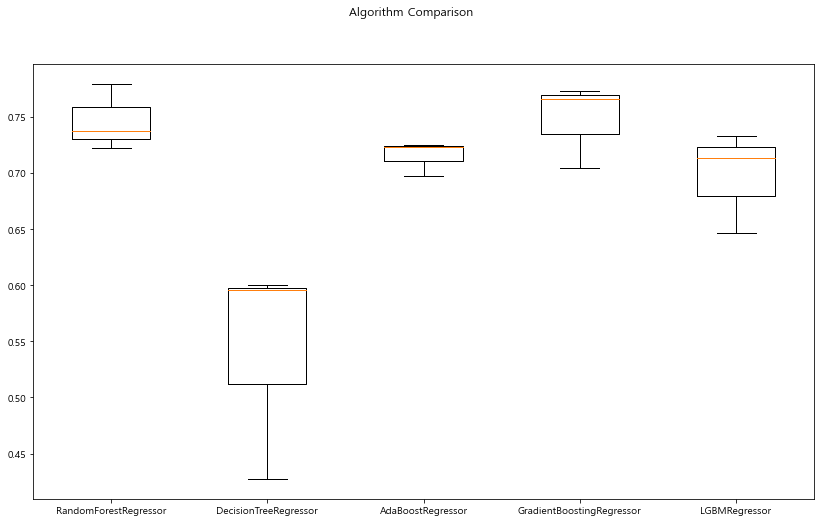

In [152]:
fig = plt.figure(figsize=(14,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [154]:
pd.DataFrame(results,
             columns = ['cv_'+str(i) for i in range(1,4)],
             index = names)

,cv_1,cv_2,cv_3
RandomForestRegressor,0.737554,0.722627,0.779697
DecisionTreeRegressor,0.599970,0.427306,0.595898
AdaBoostRegressor,0.724686,0.697840,0.723028
GradientBoostingRegressor,0.765900,0.704285,0.773010
LGBMRegressor,0.713788,0.646192,0.732855


---

In [148]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [2,4,6,8,10,15],
    'n_estimators' :  [50,100,150,200,250],
    'min_samples_leaf' : [2,4,8,12], 
    'min_samples_split' : [2,4,8,12]
}

rf_clf = RandomForestRegressor(random_state=13,n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, scoring='r2',
                      cv=5, n_jobs=-1, return_train_score=True)

grid_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 15],
                         'min_samples_leaf': [2, 4, 8, 12],
                         'min_samples_split': [2, 4, 8, 12],
                         'n_estimators': [50, 100, 150, 200, 250]},
             return_train_score=True, scoring='r2')

In [149]:
# test
rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(X_train,y_train)
# pred1 = rf_clf_best.predict(X_test)
rf_clf_best.score(X_test, y_test)

print('<Random Forest>')
print('best parameters: ', grid_cv.best_params_)
print('best validation score:',grid_cv.best_score_)
print('test score: ', rf_clf_best.score(X_test, y_test))

<Random Forest>
best parameters:  {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
best validation score: 0.746924699215074
test score:  0.858713700066944


---

In [156]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [2,4,6,8,10,15],
    'n_estimators' :  [50,100,150,200,250],
    'min_samples_leaf' : [2,4,8,12], 
    'min_samples_split' : [2,4,8,12]
}

rf_clf = RandomForestRegressor(random_state=13,n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, scoring='r2',
                      cv=3, n_jobs=-1, return_train_score=True)

grid_cv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 15],
                         'min_samples_leaf': [2, 4, 8, 12],
                         'min_samples_split': [2, 4, 8, 12],
                         'n_estimators': [50, 100, 150, 200, 250]},
             return_train_score=True, scoring='r2')

In [157]:
# test
rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(X_train,y_train)
# pred1 = rf_clf_best.predict(X_test)
rf_clf_best.score(X_test, y_test)

print('<Random Forest>')
print('best parameters: ', grid_cv.best_params_)
print('best validation score:',grid_cv.best_score_)
print('test score: ', rf_clf_best.score(X_test, y_test))

<Random Forest>
best parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
best validation score: 0.7628154697822277
test score:  0.8522592640382151


---

In [ ]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS': linear_model.LinearRegression(),
           'Lasso': GridSearchCV(linear_model.Lasso(), 
                               param_grid=lasso_params).fit(X_train, y_train),
           'Ridge': GridSearchCV(linear_model.Ridge(), 
                               param_grid=ridge_params).fit(X_train, y_train)}

In [185]:
grid_cv = GridSearchCV(linear_model.Lasso(), 
                               param_grid=lasso_params, scoring='r2',
                      cv=3, n_jobs=-1, return_train_score=True)

grid_cv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.02, 0.024, 0.025, 0.026, 0.03]},
             return_train_score=True, scoring='r2')

In [186]:
# test
lasso_clf_best = grid_cv.best_estimator_
lasso_clf_best.fit(X_train,y_train)
# pred1 = rf_clf_best.predict(X_test)
lasso_clf_best.score(X_test, y_test)

print('<lasso>')
print('best parameters: ', grid_cv.best_params_)
print('best validation score:',grid_cv.best_score_)
print('test score: ', lasso_clf_best.score(X_test, y_test))

<lasso>
best parameters:  {'alpha': 0.03}
best validation score: 0.7531925432143854
test score:  0.8401907685314308


In [182]:
grid_cv = GridSearchCV(linear_model.Ridge(), 
                               param_grid=ridge_params, scoring='r2',
                      cv=3, n_jobs=-1, return_train_score=True)

grid_cv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [200, 230, 250, 265, 270, 275, 290, 300,
                                   500]},
             return_train_score=True, scoring='r2')

In [184]:
# test
ridge_clf_best = grid_cv.best_estimator_
ridge_clf_best.fit(X_train,y_train)
# pred1 = rf_clf_best.predict(X_test)
ridge_clf_best.score(X_test, y_test)

print('<ridge>')
print('best parameters: ', grid_cv.best_params_)
print('best validation score:',grid_cv.best_score_)
print('test score: ', ridge_clf_best.score(X_test, y_test))

<ridge>
best parameters:  {'alpha': 500}
best validation score: 0.7524831721170161
test score:  0.8404195373207666


### 4-2. 모델학습

#### 단순회귀(Linear Regression)

In [67]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.8401850571637374

#### XGBoost

In [68]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

[15:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.856723664900718

#### 랜덤포레스트(RandomForest)

In [69]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.8414695667910681

---

### 4-3. 테스트 데이터 예측 결과

In [70]:
pred = xgb_model.predict(new_test)
pred

array([ 711.72095 , 1357.2263  ,  523.06354 ,  479.63263 , 1310.7996  ,
       1796.5063  ,  911.2074  ,  442.2404  ,  338.6664  ,  257.65833 ,
        403.77567 ,  290.87677 ,  350.97162 ,  260.04956 ,  353.1173  ,
        207.87929 ,  381.0579  ,  271.3371  ,  192.65858 ,  672.44385 ,
        234.29713 ,  376.9666  ,  439.0485  ,  523.9315  ,  435.17526 ,
        173.53246 ,  226.84471 ,  538.9693  ,  416.42392 ,  414.1119  ,
        967.0211  ,  105.44062 ,  419.964   ,  203.8103  ,  164.56966 ,
        292.23434 ,  368.13416 ,  605.26135 ,  827.51447 ,  285.87872 ,
        398.67203 ,  407.8571  ,  360.67764 ,  492.84665 ,  810.1927  ,
       1042.335   ,  467.4499  ,  565.6496  ,  372.16238 ,  397.96976 ,
        788.1083  ,  249.68843 ,  946.2286  ,  659.0442  ,  528.23596 ,
        250.28656 ,  584.575   ,  248.11754 ,  386.7935  ,  140.55421 ,
        351.314   ,  507.29523 ,  806.8561  ,  378.05197 ,  135.29205 ,
        214.04688 ,  493.5545  ,  791.4429  ,  543.3598  ,  382.

In [71]:
answer_sheet = pd.read_csv('sample_submission.csv')
answer_sheet

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0
...,...,...
145,C2456,0
146,C1266,0
147,C2152,0
148,C1267,0


In [72]:
submission = pd.DataFrame({
    'code': answer_sheet['code'],
    'num': pred
})

submission

,code,num
0,C1072,711.720947
1,C1128,1357.226318
2,C1456,523.063538
3,C1840,479.632629
4,C1332,1310.799561
...,...,...
145,C2456,248.753723
146,C1266,454.591034
147,C2152,66.696548
148,C1267,399.556702
